## Python enviroment configuration

In [1]:
#!pip install numpy cython
#!pip install six==1.10.0
#!pip install msrest==0.4.5
#!pip install scipy==1.0.0
#!pip install fastlmm
#!pip install argparse
#!pip install six
#!pip install msrest

#!pip install scipy
#!pip install -U turicreate
#!pip install scikit-surprise


## Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import turicreate as tc
np.set_printoptions(precision=4)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Rating dataset  and configuration

In [19]:
ratings = pd.read_csv('ratingClean.csv')#.sample(n=10)

In [20]:
ratings = ratings[['userID_auto','placeID_auto','rating']]
n = len(ratings)
ratings.info()
ratings.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 3 columns):
userID_auto     1161 non-null int64
placeID_auto    1161 non-null int64
rating          1161 non-null int64
dtypes: int64(3)
memory usage: 27.3 KB


,userID_auto,placeID_auto,rating
0,76,123,2
1,76,84,2
2,76,31,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93db0b51d0>]],
      dtype=object)

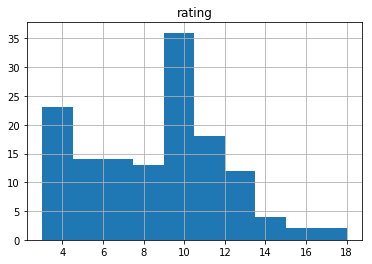

In [21]:
aux = ratings[['userID_auto','rating']]
aux.groupby('userID_auto').count().hist()

In [22]:
#msk = np.random.random(len(ratings)) < 0.7
#mskPred = ratings['rating']==0
#mskNPred = ratings['rating']!=0
#mskTrain= mskNPred & msk
#mskTest = mskNPred & ~msk
#dfPred = ratings[mskPred]
#dfTrain = ratings[mskTrain]
#dfTest = ratings[mskTest]
#a = 100*sum(mskPred)/n
#b = 100*sum(mskTrain)/n
#c = 100*sum(mskTest)/n
#d = 100*b/(b+c)
#e = 100*c/(b+c)
#print("To predict: %0.2f%% of the total" % a)
#print("To train: %0.2f%% of the total, %0.2f%% of rest" % (b, d))
#print("To test: %0.2f%%of the total, %0.2f%% of rest" % (c, e))

# 1. What would be the best recommendation for diners? Provide problem statement and codes in Python (preference) or R.
### Surprise library

In [15]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from surprise import dataset
from surprise import Reader
from surprise import evaluate, print_perf
from surprise.model_selection import cross_validate

### Model

In [26]:
from surprise import SVD

In [27]:
# You'll need to create a dummy reader
reader = Reader(line_format='user item rating', rating_scale=(1, 2))

# Also, a dummy Dataset class
class MyDataset(dataset.DatasetAutoFolds):

    def __init__(self, df, reader):

        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['userID_auto'], df['placeID_auto'], df['rating'])]
        self.reader=reader

data = MyDataset(ratings, reader)

In [30]:

# You should now be able to use the data object normally.
data.split(n_folds=3)
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)
True

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.7488  0.6971  0.6866  0.6959  0.6960  0.7568  0.6585  0.7112  0.7379  0.6741  0.7063  0.0306  
MAE (testset)     0.6490  0.5893  0.5787  0.5966  0.5835  0.6349  0.5202  0.6089  0.6123  0.5570  0.5930  0.0353  
Fit time          0.60    0.56    0.64    0.59    0.58    0.57    0.58    0.56    0.61    0.65    0.60    0.03    
Test time         0.01    0.00    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.00    


True



2.Proporciona una explicación de los supuestos que uso y sus resultados. En ingles y puede apoyarse de algún gráfico(s).

3.En el supuesto de que se incluyeran nuevos restaurantes, como estimaría su rating? Solo escriba el planteamiento de como estimaría el rating; no son necesarios códigos.


### Unitary test:

In [41]:
aux = ratings[ratings['userID_auto']==9]
items = aux['placeID_auto']
for i in items:
    print('Pred: ', algo.predict(uid=3, iid=i).est,'-', np.round(algo.predict(uid=3, iid=i).est))
    
aux.head(8)

NameError: name 'algo' is not defined

### Top 5 redommendation

In [42]:
aux.placeID_auto.max()

119

In [43]:
user = 9
aux = ratings[ratings['userID_auto']==user]
notPred = aux.placeID_auto
toPred = np.delete(np.arange(0,aux.placeID_auto.max()), notPred, axis=0)

a = [algo.predict(uid=user, iid=i).est for i in toPred]
topN = np.argsort(a)[-10:]
topNV = [a[i] for i in topN]
print(topN)
print(topNV)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


NameError: name 'algo' is not defined

# Turicreate

In [26]:
m = tc.ranking_factorization_recommender.create(tc.SFrame(ratings[mskTrain]), 
                            user_id='userID_auto', 
                            item_id='placeID_auto', 
                            target='rating')

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 627 observations with 124 users and 127 items.

Data prepared in: 0.018839s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 627 / 627 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | 0.395609                                 |

| 4       | 0.195312          | 0.364396                                 |

| 5       | 0.0976562         | 0.356798                                 |

| 6       | 0.0488281         | 0.359376                                 |

| 7       | 0.0244141         | 0.371494                                 |

| 8       | 0.012207          | 0.396461                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 0.356798                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 230us        | 0.484347          | 0.496775              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 18.791ms     | 0.473837          | 0.497903              | 0.0976562   |

| 2       | 27.048ms     | 0.415341          | 0.467649              | 0.0580668   |

| 3       | 50.273ms     | 0.392812          | 0.449546              | 0.042841    |

| 4       | 62.097ms     | 0.385315          | 0.447347              | 0.0345267   |

| 5       | 70.341ms     | 0.378925          | 0.442882              | 0.029206    |

| 6       | 94.39ms      | 0.374702          | 0.438886              | 0.0254734   |

| 11      | 126.304ms    | 0.366711          | 0.430399              | 0.016168    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.352005

Final training RMSE: 0.4194

In [27]:
orig = ratings[mskNPred].rating
pred = m.predict(tc.SFrame(ratings[mskNPred]))
100*np.sum(orig==np.round(pred))/len(orig)

70.78280044101433

### Unitary test:

In [ ]:
#recommendations = m.recommend()
recommendations = m.recommend(users=[9], k=5)
recommendations['roundScore'] = np.round(recommendations['score'])
recommendations

# Scratch Collaborative filtering model

In [ ]:
# sklearn function for calculate pair distances
#   posible metrics: cosine, euclidean or Pearson correlation
from sklearn.metrics.pairwise import pairwise_distances
n_users = ratings.userID_auto.max()
n_items = ratings.placeID_auto.max()

cbMatrix = np.zeros((n_users, n_items))
for line in ratings.itertuples():
    cbMatrix[line[1]-1, line[2]-1] = line[3]
    
### User-User filtering
user_similarity = pairwise_distances(cbMatrix, metric='cosine')
mean_user_rating = cbMatrix.mean(axis=1)
ratings_diff = (cbMatrix - mean_user_rating[:, np.newaxis])
user_prediction = mean_user_rating[:, np.newaxis] + np.dot(user_similarity, ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T

### Item-Item filtering
item_similarity = pairwise_distances(cbMatrix.T, metric='cosine')
item_prediction = np.dot(cbMatrix,item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])